# Numerische Methoden für Differentialgleichungen
## Aufgabenblatt 7
*gelöst von Stollmayer Max*

Für die Konvektionsgleichung

\begin{cases}
\begin{align*}
\partial_t u(x,t) + a\cdot\partial_x u(x,t) = 0,& \quad x\in D,\ t\ge 0 \\
u(x,0)=\sin(2\pi x),& \quad x\in D \\
u(0,t)=u(1,t),& \quad t\ge 0
\end{align*}
\end{cases}

mit konstantem Koeffizient $a = -1$ und $D = [0,1]$ ist das Upwind- und das Lax-Friedrichs-Verfahren zu implementieren. Dabei ist der Zeitschritt $k$ so zu wählen, dass die Stabilitätsbedingung $|a|\frac{k}{h} \le 1$ erfüllt ist.
Die Verfahren sind für 50 und 400 Gitterpunkte in Ortsrichtung mit der exakten Lösung zu den Zeiten $T=0.5$ und $T=1$ zu vergleichen.

In [1]:
import numpy as np 
from matplotlib import pyplot as plt

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11.2, 6.3))
plt.rc("font", size=12)
plt.rc("axes", edgecolor="white")
plt.rc("legend", frameon=True, framealpha= 0.8, facecolor="white", edgecolor="white")

Erklärung Upwind

In [93]:
def Upwind(a, u0, grid):
    '''
    Solves the one-dimensional, linear, hyperbolic PDE u_t + a * u_x = 0 with initial value function u0
    and periodic boundary values on the griven grid using the Upwind scheme.
    
    returns 2D-array of function values
    
    a ...... constant
    u0 ..... intial value function in the x variable
    grid ... tuple (x, t) where x and t are N-by-M-arrays
    '''
    
    
    x, t = grid
    N, M = x.shape
    
    u = np.zeros((N, M))
    u[0] = u0(x[0])
    
    if a >= 0:
        for n in range(N-1):
            
            # values on inner grid
            for m in range(1, M):
                dx = x[n, m] - x[n, m-1]
                dt = t[n+1, m] - t[n, m]
                u[n+1, m] = u[n, m] - a * dt / dx * (u[n, m] - u[n, m-1])
            
            # periodic boundary values
            u[n+1, 0] = u[n+1, -1]
    else:
        for n in range(N-1):
            
            # values on inner grid
            for m in range(M-1):
                dx = x[n, m+1] - x[n, m]
                dt = t[n+1, m] - t[n, m]
                u[n+1, m] = u[n, m] - a * dt / dx * (u[n, m+1] - u[n, m])
                
            # periodic boundary values
            u[n+1, -1] = u[n+1, 0]
    
    return u

Erklärung Lax-Friedrichs

In [92]:
def LaxFriedrichs(a, u0, grid):
    '''
    Solves the one-dimensional, linear, hyperbolic PDE u_t + a * u_x = 0 with initial value function u0
    and periodic boundary values on the griven grid using the Lax-Friedrichs method.
    
    returns 2D-array of function values
    
    a ...... constant
    u0 ..... intial value function in the x variable
    grid ... tuple (x, t) where x and t are N-by-M-arrays
    '''
    
    
    x, t = grid
    N, M = x.shape
    
    u = np.zeros((N, M))
    u[0] = u0(x[0])
    
    for n in range(N-1):
        
        # values on inner grid
        for m in range(1, M-1):
            dx = x[n, m+1] - x[n, m-1]
            dt = t[n+1, m] - t[n, m]
            u[n+1, m] = (u[n, m+1] + u[n, m-1]) / 2 - a * dt / dx * (u[n, m+1] - u[n, m-1])
        
        # periodic boundary values
        dx = x[n, -1] - x[n, -2] + x[n, 1] - x[n, 0]
        dt = t[n+1, 0] - t[n, 0]
        u[n+1, 0] = u[n+1, -1] = (u[n, 1] + u[n, -2]) / 2 - a * dt / dx * (u[n, 1] - u[n, -2])
        
    return u

Test anhand von ...

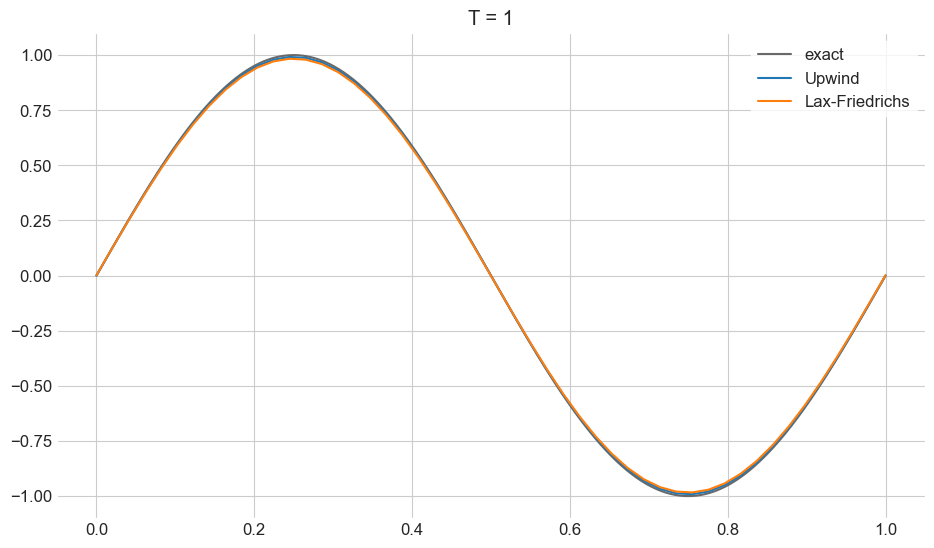

In [107]:
a = -1

def u0(x):
    return np.sin(2 * np.pi * x)

def exact(x, t):
    return u0(x - a * t)

N = 50
M = N+1
x = np.linspace(0, 1, N)
t = np.linspace(0, 1, M)
grid = np.meshgrid(x, t)

u1 = Upwind(a, u0, grid)
u2 = LaxFriedrichs(a, u0, grid)

X = np.linspace(0, 1, 1000)
plt.plot(X, exact(X, 1), color="dimgray", label="exact")
plt.plot(x, u1[-1], label="Upwind")
plt.plot(x, u2[-1], label="Lax-Friedrichs")
plt.title(f"T = 1")
plt.legend()
plt.show()

In [4]:
def error(exact_vals, approx_vals):
    '''Maxmimum norm'''
    return max(np.abs(exact_vals.flatten() - approx_vals.flatten()))

def order(err1, err2, h1, h2):
    '''Approximation of order of convergence'''
    return np.log(err2 / err1) / np.log(h2 / h1)

def OUTPUT(a, u0, exact, D, Ns, Ts, c):
    '''Prints errors for all N and generates plots for each T'''
    
    Ts.sort()
    Ns.sort()
    S = np.array([D, [0, Ts[-1]]])
    fig, axs = plt.subplots(len(Ts), 1)
    
    print("Error   |  Upwind  | Lax-Friedrichs")
    
    U_errors = ()
    L_errors = ()
    
    for N in Ns:
        U = Upwind(a, u0, S, N, c=c)
        L = LaxFriedrichs(a, u0, S, N, c=c)
        M = U.shape[0]
        x = np.linspace(D[0], D[1], N+1)
        t = np.linspace(0, Ts[-1], M)
        exact_vals = exact(x[None, :], t[:, None])
        U_err = error(exact_vals, U)
        L_err = error(exact_vals, L)
        U_errors += (U_err,)
        L_errors += (L_err,)
        
        print(f"N = {N:3.0f} | {U_err:.2e} | {L_err:11.2e}")
        
        for i, T in enumerate(Ts):
            ind = int((M-1) / Ts[-1] * T)
            axs[i].plot(x, U[ind], label=f"N={N}, Upwind")
            axs[i].plot(x, L[ind], label=f"N={N}, Lax-Friedrichs")
    
    h1 = (D[1] - D[0]) / Ns[-2]
    h2 = (D[1] - D[0]) / Ns[-1]
    U_order = order(U_errors[-2], U_errors[-1], h1, h2)
    L_order = order(L_errors[-2], L_errors[-1], h1, h2)
    print(f"Order   |     {U_order:.0f}    |\t   {L_order:.0f}")
    
    x = np.linspace(D[0], D[1], 100)
    for i, T in enumerate(Ts):
        axs[i].plot(x, exact(x, T), "dimgray", label="exact")
        axs[i].set_ylabel(f"T = {T}")
    axs[0].legend(fontsize=10)
    axs[0].set_title(f"Comparison for c = {c}")
    plt.show()

error   |  Upwind  | Lax-Friedrichs
N =  50 | 7.14e-02 |    9.58e-02
N = 400 | 7.95e-03 |    1.20e-02
order   |     1    |	   1


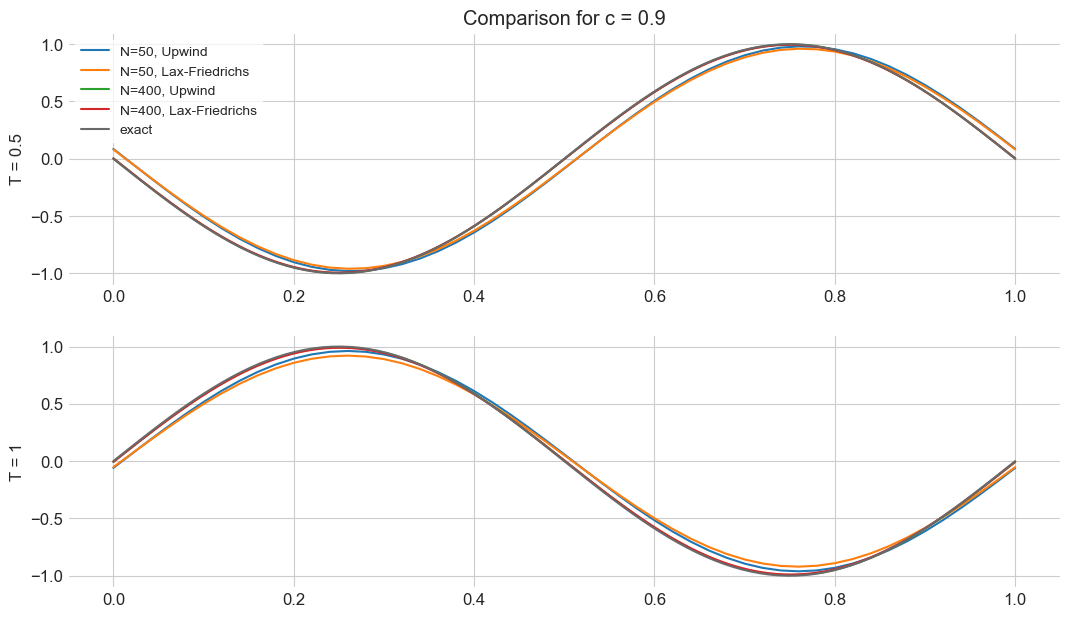

In [5]:
a = -1
D = [0, 1]
Ns = [50, 400]
Ts = [0.5, 1]
c = 0.9  # 0 < c <= 1 to satisfy CFL stability condition

def u0(x):
    return np.sin(2 * np.pi * x)

def exact(x, t):
    return u0(x - a * t)

OUTPUT(a, u0, exact, D, Ns, Ts, c)

Beobachtungen